# Advanced Usage

In [1]:
### depending on which directory you run your notebook from
### you could locate pyroma package like this

import sys
#sys.path.append('/path/to/your/directory/pyroma/')
sys.path.append('/home/az/Projects/01_Curie/05_pyROMA/pyroma/')

In [2]:
import pyroma
roma = pyroma.ROMA()
roma

scROMA

In [3]:
import os
import zipfile
import io
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.io
from glob import glob

In [4]:
print(os.getcwd())

/home/az/Projects/01_Curie/05_pyROMA/pyroma/docs/source/tutorial


In [5]:
os.chdir('/home/az/Projects/01_Curie/05_pyROMA/pyroma')

In [6]:
datasets_dir = "datasets"

adata = sc.read_h5ad(os.path.join(datasets_dir, "rna_10xpmbc3k.h5ad"))
adata


AnnData object with n_obs × n_vars = 2700 × 32738
    obs: 'celltype'
    var: 'gene_ids'

### standard preprocessing

In [7]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [8]:
adata

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'celltype', 'n_genes'
    var: 'gene_ids', 'n_cells'
    uns: 'log1p'

### run pyroma

In [ ]:
import time

genesets_dir = "genesets"
roma.gmt =os.path.join(genesets_dir, "h.all.v2023.1.Hs.symbols.gmt")

roma.adata = adata
roma.pc_sign_mode = 'UseMeanExpressionAllWeights'
pathways_to_check = 'all' #['HALLMARK_NOTCH_SIGNALING', 'HALLMARK_PANCREAS_BETA_CELLS', 'HALLMARK_TGF_BETA_SIGNALING' ] 

iters = 100

start = time.time()
roma.compute(pathways_to_check, 
             parallel=True,
             loocv_on=True,
            iters=iters,
            )
end = time.time()

minutes, seconds = divmod(end - start, 60)
print(f"CPU Parallel {iters} iterations for shape {adata.shape}, running time (min): " + "{:0>2}:{:05.2f}".format(int(minutes),seconds))


Processing gene set: HALLMARK_NOTCH_SIGNALING | len of subsetlist: 25 
Running time: 00:06.23
Processing gene set: HALLMARK_PANCREAS_BETA_CELLS | len of subsetlist: 14 
Using existing null distribution
Processing gene set: HALLMARK_TGF_BETA_SIGNALING | len of subsetlist: 47 
Running time: 00:07.89
Finished: CPU Parallel 10 iterations for shape (2700, 13714), running time (min): 00:23.62


In [10]:
roma

scROMA: module activities are computed

In [11]:
roma.adata

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'celltype', 'n_genes'
    var: 'gene_ids', 'n_cells'
    uns: 'log1p', 'ROMA', 'ROMA_stats', 'ROMA_active_modules'

### all the pyroma statistics

In [12]:
roma.adata.uns['ROMA_stats']

,L1,ppv L1,Median Exp,ppv Med Exp,q L1,q Med Exp
HALLMARK_NOTCH_SIGNALING,0.308422,0.5,0.046337,0.272727,0.50,0.818182
HALLMARK_PANCREAS_BETA_CELLS,0.329635,0.3,-0.002735,1.000000,0.45,1.000000
HALLMARK_TGF_BETA_SIGNALING,0.234389,0.2,-0.024408,0.727273,0.45,1.000000


### active pathways

In [13]:
roma.adata.uns['ROMA_active_modules'].sort_values(by='Median Exp')

,L1,ppv L1,Median Exp,ppv Med Exp,q L1,q Med Exp


### visualize results

In [14]:
sc.pp.pca(roma.adata)
sc.pp.neighbors(roma.adata)
sc.tl.umap(roma.adata)

In [15]:
adata.obs

,celltype,n_genes
AAACATACAACCAC-1,CD4 T,781
AAACATTGAGCTAC-1,B,1352
AAACATTGATCAGC-1,CD4 T,1131
AAACCGTGCTTCCG-1,CD14 Monocytes,960
AAACCGTGTATGCG-1,NK,522
...,...,...
TTTCGAACTCTCAT-1,CD14 Monocytes,1155
TTTCTACTGAGGCA-1,B,1227
TTTCTACTTCCTCG-1,B,622
TTTGCATGAGAGGC-1,B,454


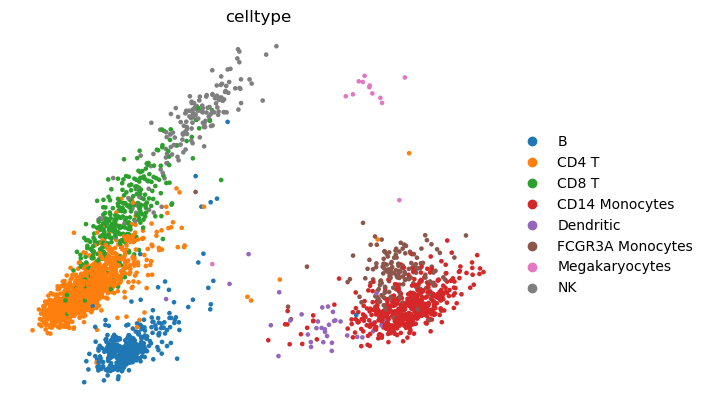

In [16]:
sc.pl.pca(adata, color=['celltype',
                                ],
                                frameon=False,
                                ncols=2,
                                wspace=0.4)

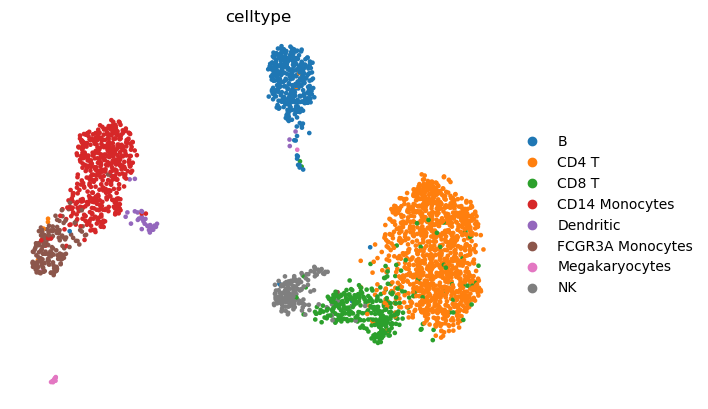

In [17]:
sc.pl.umap(adata, color=['celltype',
                                ],
                                frameon=False,
                                ncols=2,
                                wspace=0.4)

In [18]:
geneset_name = 'HALLMARK_INFLAMMATORY_RESPONSE'

roma.adata.obs[f'{geneset_name}_projections_1'] = roma.adata.uns['ROMA'][f'{geneset_name}'].svd.components_[0]
roma.adata.obs[f'{geneset_name}_projections_1_reverse'] = -1 * roma.adata.uns['ROMA'][f'{geneset_name}'].svd.components_[0]

GeneScores = pd.DataFrame(roma.adata.uns['ROMA'][f'{geneset_name}'].projections_1,
                index=roma.adata.uns['ROMA'][f'{geneset_name}'].subsetlist,
                columns=[f'{geneset_name}'])

sc.pl.pca(adata, color=['celltype',
                                f'{geneset_name}_projections_1'],
                                frameon=False,
                                ncols=2,
                                wspace=0.4)

sc.pl.umap(adata, color=['celltype',
                                f'{geneset_name}_projections_1'],
                                frameon=False,
                                ncols=2,
                                wspace=0.4)

KeyError: 'HALLMARK_INFLAMMATORY_RESPONSE'

In [ ]:
GeneScores

,HALLMARK_INFLAMMATORY_RESPONSE
CXCL10,-0.170376
CCL2,-0.171694
CCL5,45.372082
FPR1,-3.665694
CCL20,0.093291
...,...
STAB1,-0.306701
IRF1,1.357086
ICAM4,-0.329905
P2RX4,-0.153743


In [ ]:
# optional: to load pathway-genes dictionary 
genesets = roma.read_gmt_to_dict(roma.gmt)


### save and load results

In [ ]:
save_dir = 'results'

roma.save_active_modules_results(path=save_dir)   

In [ ]:
del roma.adata

In [ ]:
#roma.adata

In [ ]:
load_dir = 'results'

roma.load_active_modules_results(path=save_dir)   

In [ ]:
roma.adata

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'celltype', 'n_genes', 'HALLMARK_INFLAMMATORY_RESPONSE_projections_1', 'HALLMARK_INFLAMMATORY_RESPONSE_projections_1_reverse'
    var: 'gene_ids', 'n_cells'
    uns: 'ROMA_active_modules', 'ROMA_stats', 'celltype_colors', 'log1p', 'neighbors', 'pca', 'umap', 'ROMA'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

### top contributing genes

In [ ]:
GeneScores.sort_values(by=geneset_name)

,HALLMARK_INFLAMMATORY_RESPONSE
LY6E,-9.469896
TIMP1,-8.930674
CD14,-7.395456
NFKBIA,-5.897358
RHOG,-4.730138
...,...
CD69,3.288985
IL7R,6.165412
IFITM1,6.817437
LCK,8.328794


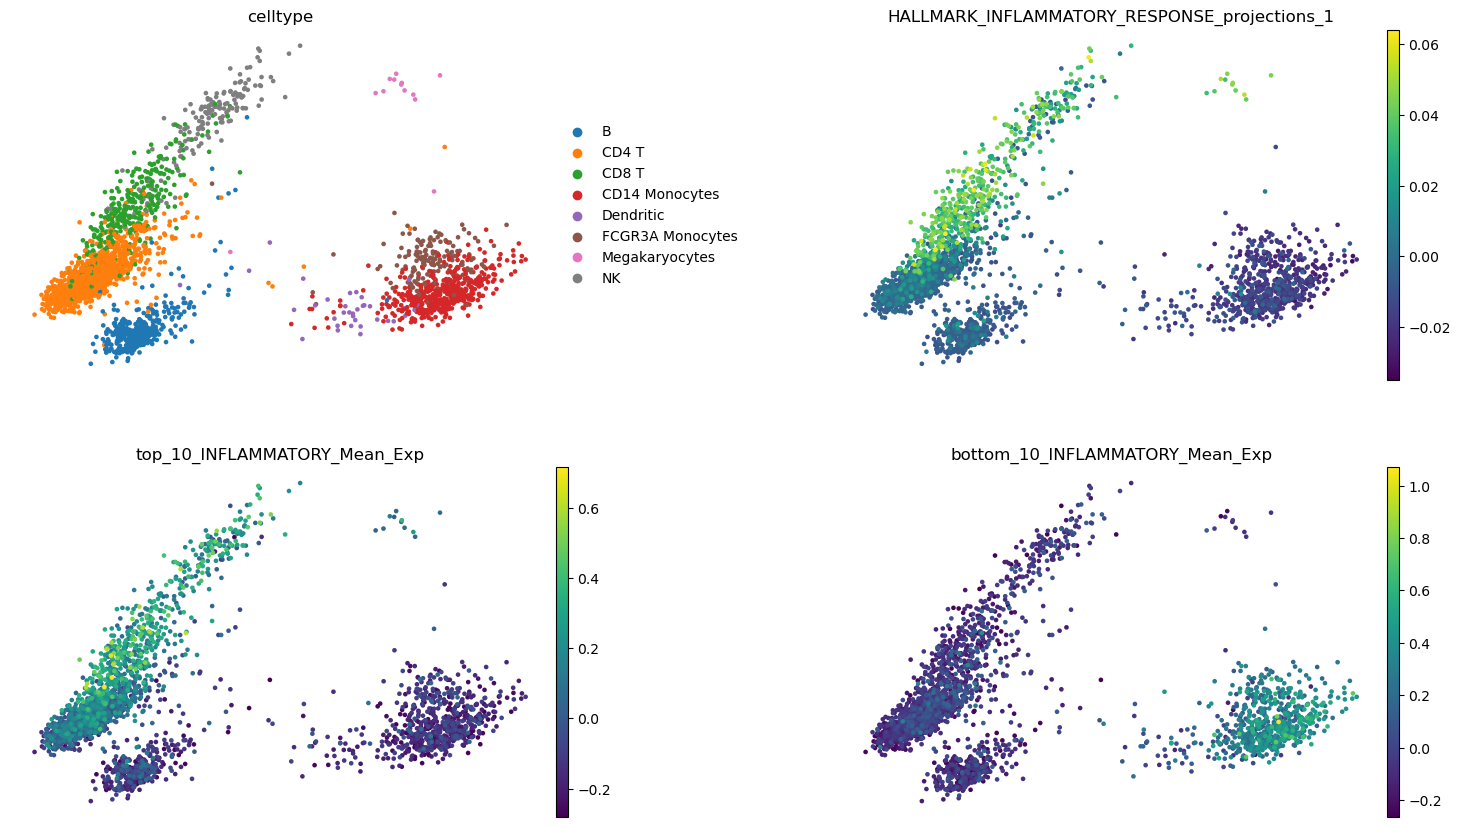

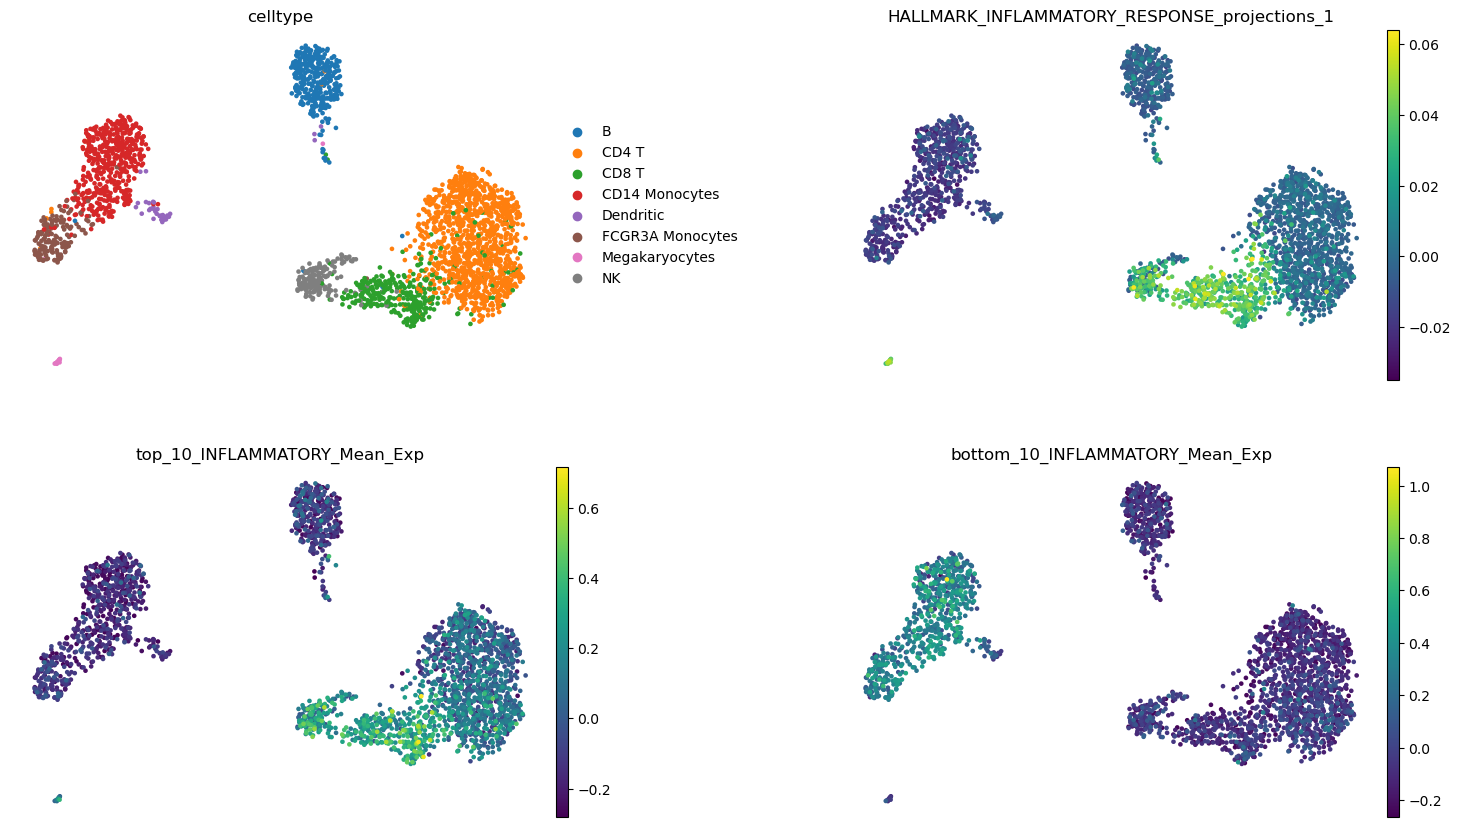

In [ ]:
# number of top and bottom genes
n_top = 10
short_name = geneset_name.split('_')[1]

top_n = GeneScores.sort_values(by=f'{geneset_name}', ascending=False).head(n_top).index.tolist()
bottom_n = GeneScores.sort_values(by=f'{geneset_name}', ascending=False).tail(n_top).index.tolist()

top_mean_exp = roma.adata[:, top_n].X.mean(axis=1)
bottom_mean_exp = roma.adata[:, bottom_n].X.mean(axis=1)

roma.adata.obs[f'top_{n_top}_{short_name}_Mean_Exp'] = top_mean_exp
roma.adata.obs[f'bottom_{n_top}_{short_name}_Mean_Exp'] = bottom_mean_exp

sc.pl.pca(roma.adata, color=['celltype',
                                f'{geneset_name}_projections_1',
                                f'top_{n_top}_{short_name}_Mean_Exp',
                                f'bottom_{n_top}_{short_name}_Mean_Exp'], 
                                frameon=False,
                                ncols=2,
                                wspace=0.4)

sc.pl.umap(roma.adata, color=['celltype',
                                f'{geneset_name}_projections_1',
                                f'top_{n_top}_{short_name}_Mean_Exp',
                                f'bottom_{n_top}_{short_name}_Mean_Exp'], 
                                frameon=False,
                                ncols=2,
                                wspace=0.4)


### end